In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.fft import rfft, rfftfreq, irfft

In [2]:
from scipy.signal import find_peaks
from scipy.signal import savgol_filter

In [3]:
%matplotlib inline

In [4]:
def build_feature(df, resample='1D'):
    df['return'] = df.close.pct_change()
#     df['MA5'] = df['return'].rolling(5).mean()
#     df['MA10'] = df['return'].rolling(10).mean()
    df['MA20'] = df['return'].rolling(20).mean()
    df['timestamp'] = pd.to_datetime(df['timestamp'],unit='s')
    df = df.set_index('timestamp')
    df = df.resample(resample).last()
    df = df.dropna()
    return df

In [5]:
def build_dfs(resample='10D', cryptos=None):
    
    names = ['timestamp', 'open', 'high', 'low', 'close','volume', 'trade']
    dfs = []
    t_min = pd.to_datetime('2013-01-01')
    for crypto in cryptos:
        df = pd.read_csv(f'./data/{crypto}USD_1440.csv', names=names)
        df = build_feature(df, resample)
        t_min = max(t_min, df.index[0])
        dfs.append(df)

    dfs = [df[df.index > t_min] for df in dfs]
    return dfs

In [28]:
def plot(dfs, resample='10D', x='MA20'):
    
    sample_rate = int(resample[:-1])
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(28, 10))
    
    amps = []
    for i, df in enumerate(dfs):
        ax[0].plot(df.index, df[x], label=f'{cryptos[i]}_{resample}_{x}')
        ax[0].set_title(f'Time domain')
        ax[0].legend()

        yf = rfft(df[x].values)
        xf = rfftfreq(len(df), 1 / sample_rate)
        amp = np.abs(yf)
        print(xf.shape)
#         print('xf', xf)
#         print('yf', yf)
        
        amps.append(amp)

        ax[1].plot(xf, amp, label=f'{cryptos[i]}_{resample}_{x}')
        ax[1].set_title(f'Freq domain')
        ax[1].legend()
#     fig.savefig(f'./10_20MA/{resample}_{x}_{i}.jpg', dpi=300)
    amps = np.array(amps)
    mean = amps.mean(axis=0)
    median = np.median(amps, axis=0)
    
    fig2, ax2 = plt.subplots(nrows=1, ncols=2, figsize=(28, 10))
    ax2[0].plot(xf, mean)
    ax2[0].set_title(f'mean')
    ax2[1].plot(xf, median)
    ax2[1].set_title(f'median')
    
    peaks1, _ = find_peaks(mean, prominence=0.2)
    peaks2, _ = find_peaks(median, prominence=0.2)
    
    fig3, ax3 = plt.subplots(nrows=1, ncols=2, figsize=(28, 10))
    ax3[0].plot(peaks1, mean[peaks1])
    ax3[0].set_title(f'mean peaks')
    ax3[1].plot(peaks2, median[peaks2])
    ax3[1].set_title(f'median peaks')
    
    s1 = savgol_filter(mean, 9, 3)
    s2 = savgol_filter(median, 9, 3)
    
    fig4, ax4 = plt.subplots(nrows=1, ncols=2, figsize=(28, 10))
    ax4[0].plot(xf, s1)
    ax4[0].set_title(f'mean savgol')
    ax4[1].plot(xf, s2)
    ax4[1].set_title(f'median savgol')

    indices1 = mean > 0.2
    indices2 = median > 0.2
    indices3 = s1 > 0.2
    indices4 = s2 > 0.2
    
    
    reversed_x1 = irfft(indices1*yf)
    reversed_x2 = irfft(indices2*yf)
    
    fig5, ax5 = plt.subplots(nrows=1, ncols=2, figsize=(28, 10))
    ax5[0].plot(df.index[1:], reversed_x1)
    ax5[0].set_title(f'mean time domain')
    ax5[1].plot(df.index[1:], reversed_x2)
    ax5[1].set_title(f'median time domain')
    
    
    reversed_x3 = irfft(indices3*yf)
    reversed_x4 = irfft(indices4*yf)
    
    fig6, ax6 = plt.subplots(nrows=1, ncols=2, figsize=(28, 10))
    ax6[0].plot(df.index[1:], reversed_x1)
    ax6[0].set_title(f'mean savgol time domain')
    ax6[1].plot(df.index[1:], reversed_x2)
    ax6[1].set_title(f'median savgol time domain')
    
    
    

(100,)
(100,)
(100,)
(100,)


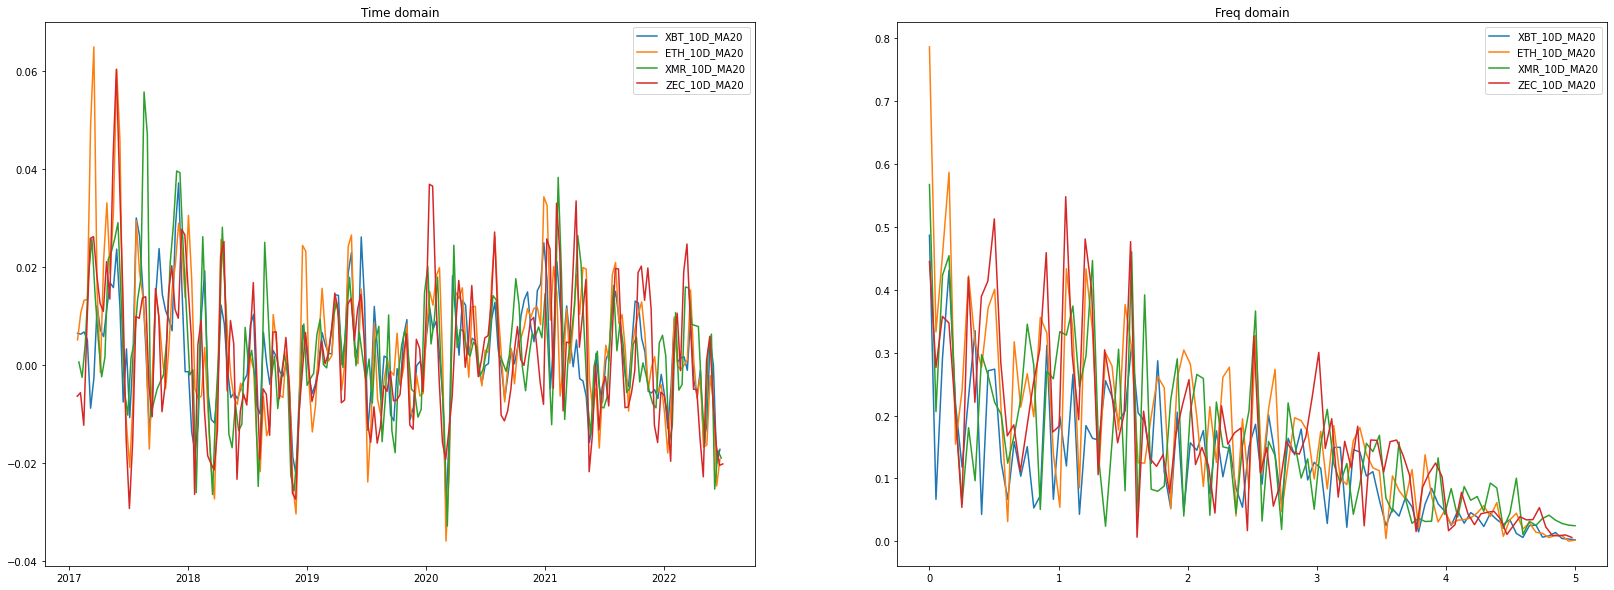

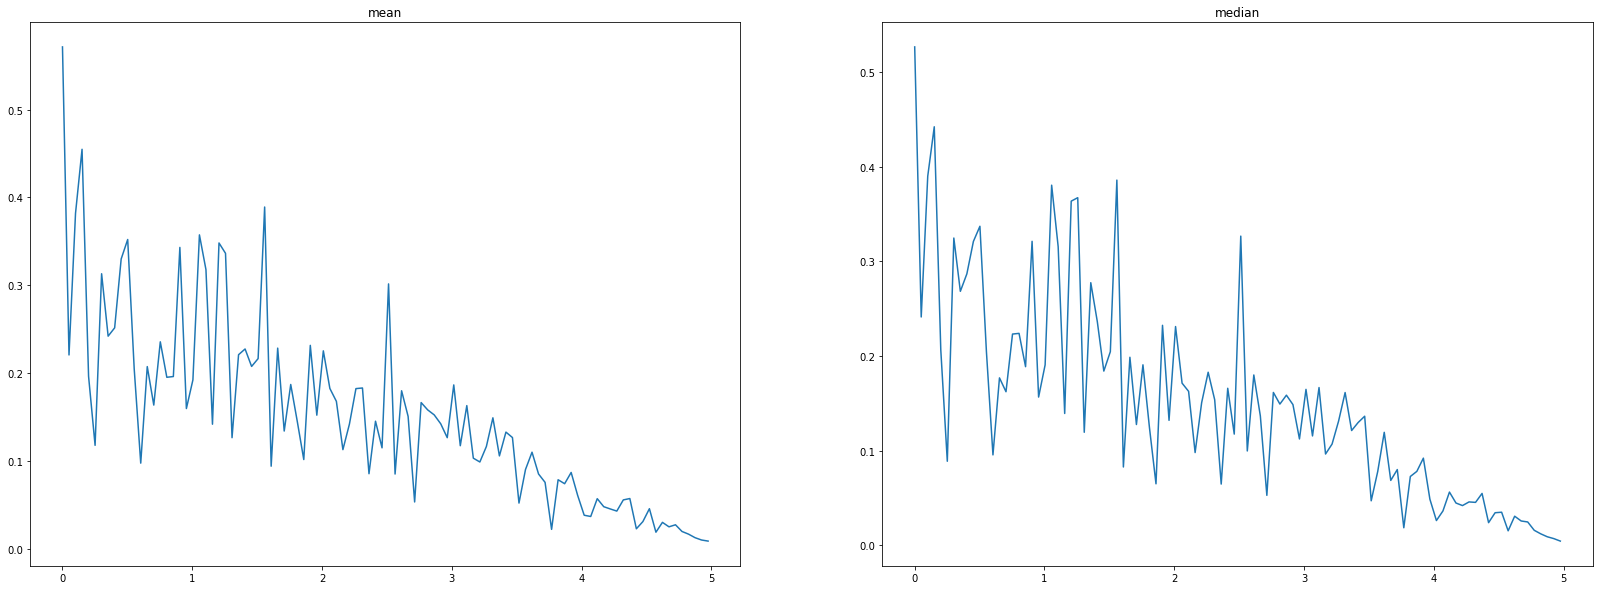

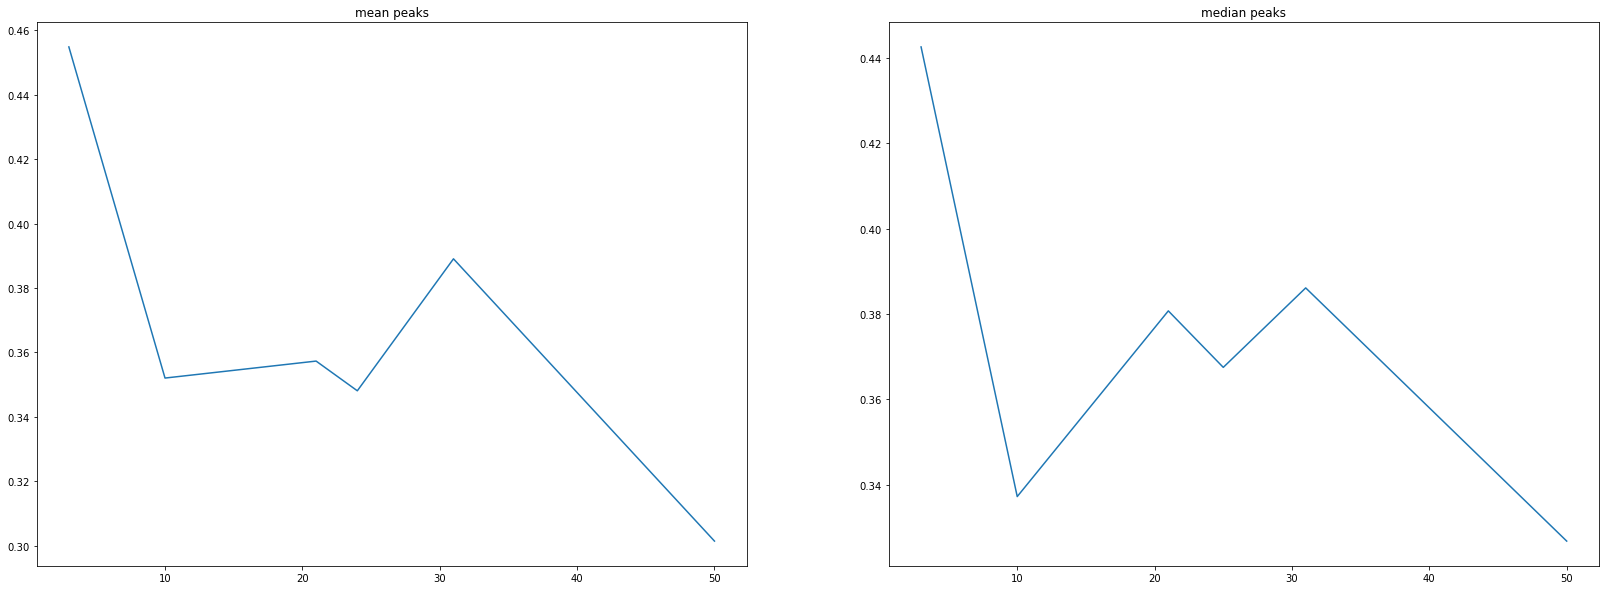

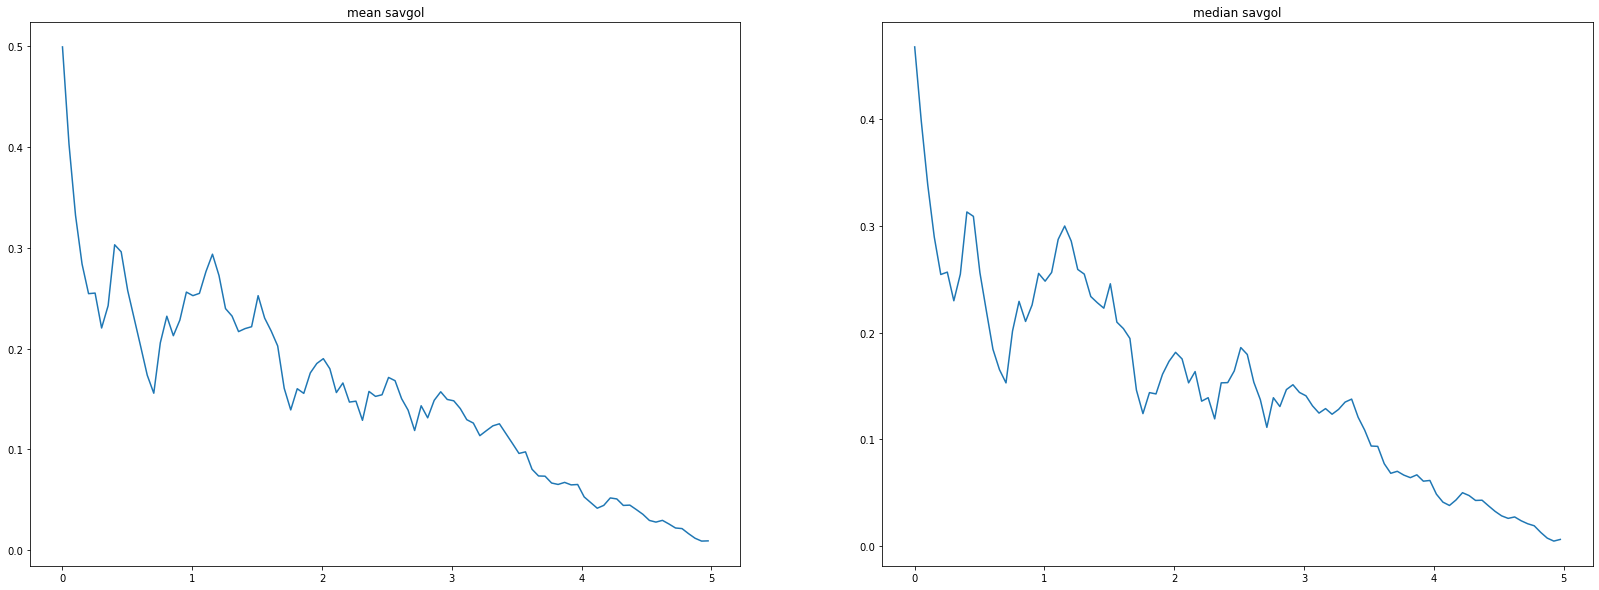

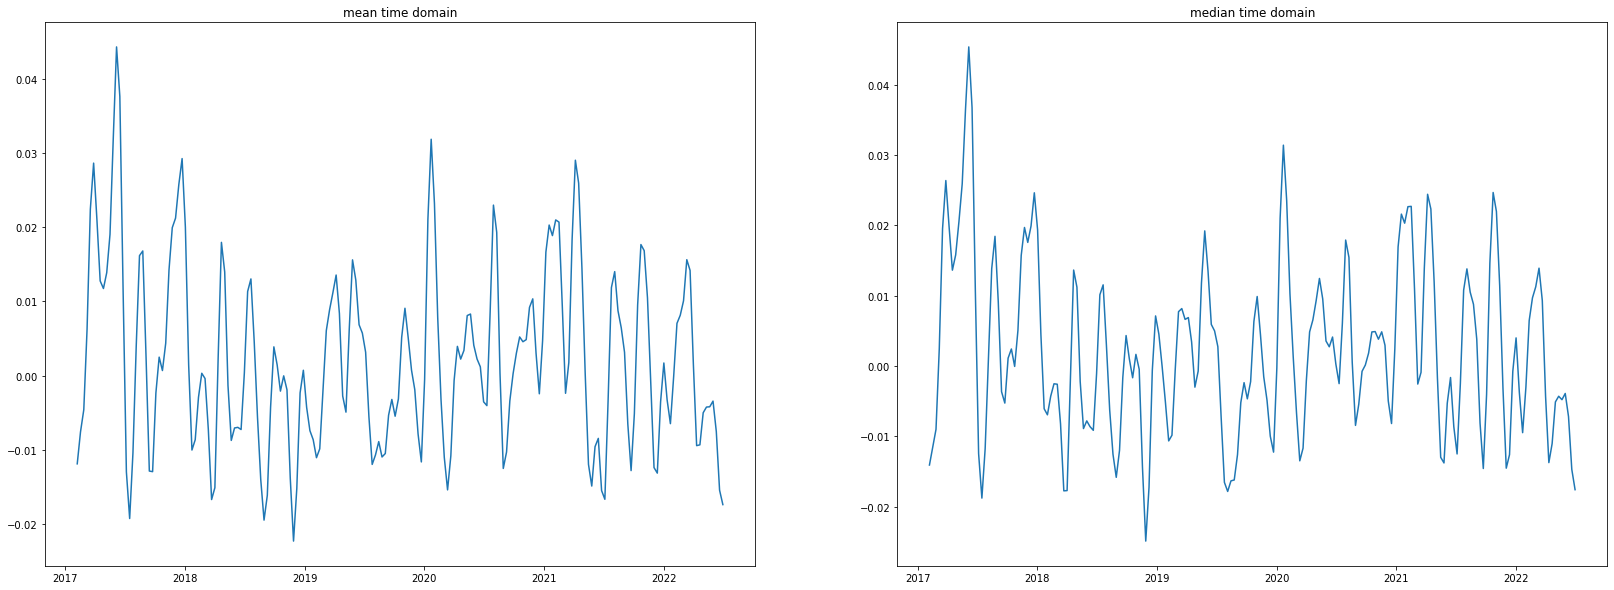

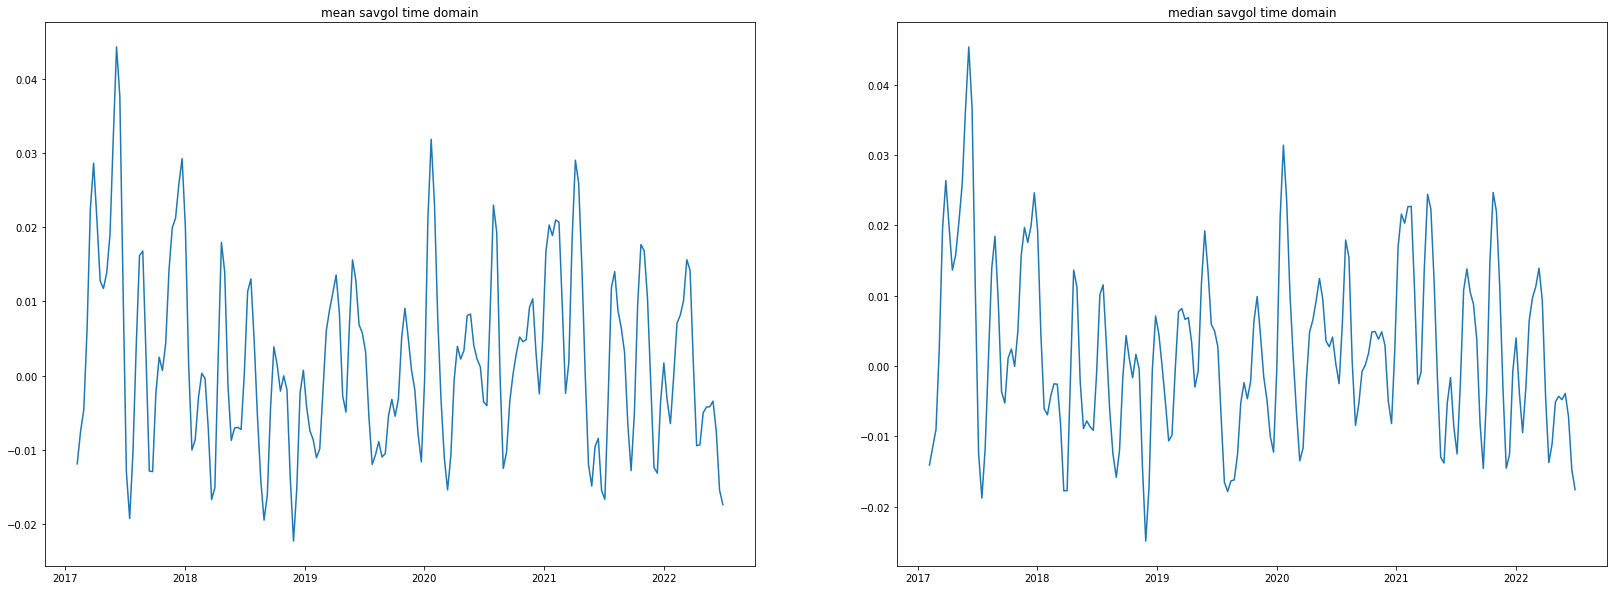

In [29]:
cryptos = ['XBT', 'ETH', 'XMR', 'ZEC']
dfs = build_dfs('10D', cryptos)
plot(dfs, '10D', 'MA20')